In [11]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

from scipy.stats import pearsonr

from splirent.data.splirent_data_5ss_aligned import load_data


In [5]:
#Load data generators

batch_size = 32

file_path = '../data/a5ss/processed_data/'
data_version = ''#'_neg_rate_1'
targeted_a5ss_file_path = '../data/targeted_a5ss/processed_data/'#None#

valid_set_size = 0.05#10000
test_set_size = 0.05#10000


splicing_gens = load_data(
    batch_size=batch_size,
    valid_set_size=valid_set_size,
    test_set_size=test_set_size,
    sequence_padding=5,
    file_path=file_path,
    data_version=data_version,
    use_shifter=False,
    targeted_a5ss_file_path=targeted_a5ss_file_path
)

truncated_n = int(len(splicing_gens['test']) * batch_size)


Aligned targeted a5ss data.
padded_c_HEK.shape = (9493, 261)
padded_c_HELA.shape = (9493, 261)
padded_c_MCF7.shape = (9493, 261)
padded_c_CHO.shape = (9493, 261)
Training set size = 835493
Validation set size = 46416
Test set size = 46416


In [12]:
#Load model
save_dir_path = '../saved_models'

model_name = 'aparent_splirent_aligned_batchnorm_drop_02_adam_shifter_targeted_a5ss'

model_path = os.path.join(save_dir_path, model_name + '.h5')

splicing_model = load_model(model_path)

<h2>Evaluate the Splicing CNN</h2>

Here we run our Splicing CNN on the Test set data generator (using Keras predict_generator).<br/>
We then compare our predictions of splice donor usage against the true RNA-Seq measurements.<br/>


1450/1450 [==============================] - 134s 92ms/step
Test set R^2 = 0.91, p = 0.0


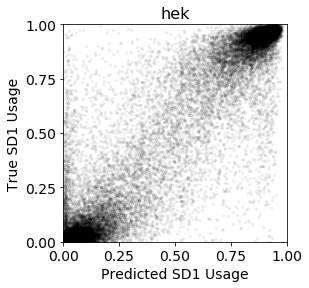

Test set R^2 = 0.92, p = 0.0


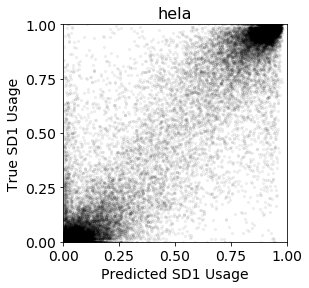

Test set R^2 = 0.9, p = 0.0


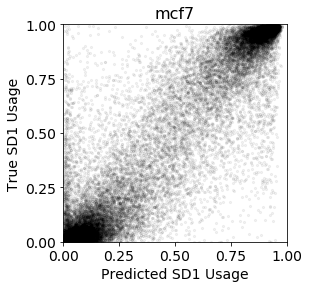

Test set R^2 = 0.92, p = 0.0


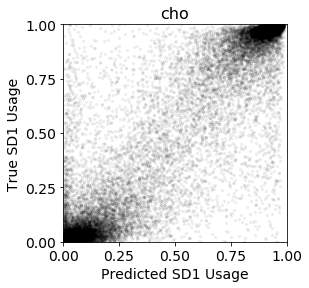

In [13]:
#Evaluate predictions on test set

predictions = splicing_model.predict_generator(splicing_gens['test'], workers=4, use_multiprocessing=True, verbose=1)
pred_usage_hek, pred_usage_hela, pred_usage_mcf7, pred_usage_cho = [np.ravel(prediction) for prediction in predictions]

targets = zip(*[splicing_gens['test'][i][1] for i in range(len(splicing_gens['test']))])
true_usage_hek, true_usage_hela, true_usage_mcf7, true_usage_cho, nonzero_count_hek, nonzero_count_hela, nonzero_count_mcf7, nonzero_count_cho = [np.ravel(np.concatenate(list(target))) for target in targets]

cell_lines = [
    ('hek', (pred_usage_hek, true_usage_hek)),
    ('hela', (pred_usage_hela, true_usage_hela)),
    ('mcf7', (pred_usage_mcf7, true_usage_mcf7)),
    ('cho', (pred_usage_cho, true_usage_cho))
]

for cell_name, [y_pred, y_true] in cell_lines :
    
    r_val, p_val = pearsonr(y_pred, y_true)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    #Plot test set scatter
    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred, y_true, color='black', s=5, alpha=0.05)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Predicted SD1 Usage', fontsize=14)
    plt.ylabel('True SD1 Usage', fontsize=14)
    plt.title(str(cell_name), fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.show()


hek vs. hela
Delta PSI Test set R^2 = 0.09, p = 0.0


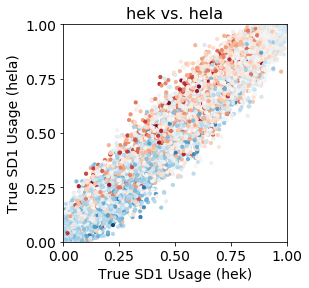

hek vs. mcf7
Delta PSI Test set R^2 = 0.45, p = 0.0


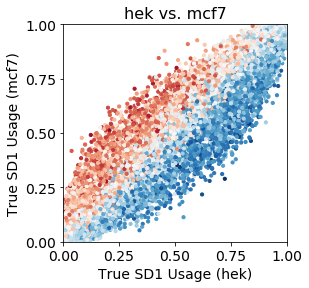

hek vs. cho
Delta PSI Test set R^2 = 0.27, p = 0.0


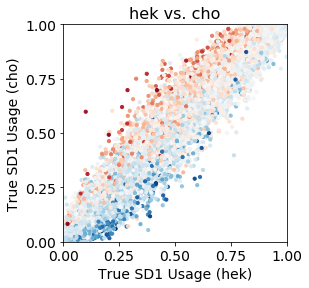

hela vs. hek
Delta PSI Test set R^2 = 0.09, p = 0.0


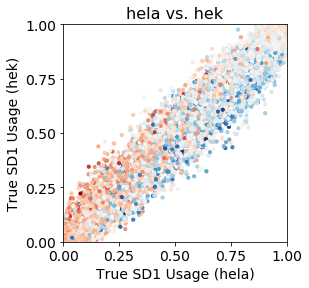

hela vs. mcf7
Delta PSI Test set R^2 = 0.47, p = 0.0


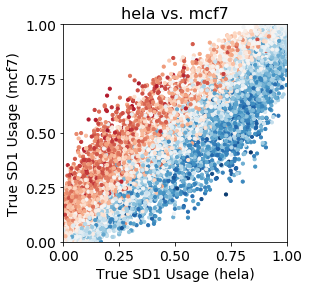

hela vs. cho
Delta PSI Test set R^2 = 0.12, p = 0.0


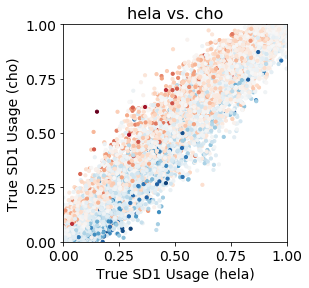

mcf7 vs. hek
Delta PSI Test set R^2 = 0.45, p = 0.0


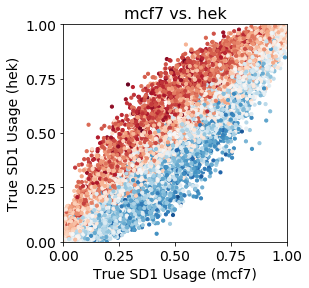

mcf7 vs. hela
Delta PSI Test set R^2 = 0.47, p = 0.0


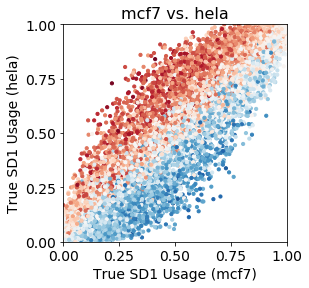

mcf7 vs. cho
Delta PSI Test set R^2 = 0.54, p = 0.0


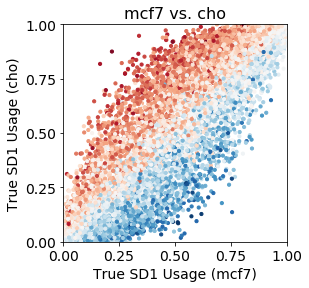

cho vs. hek
Delta PSI Test set R^2 = 0.27, p = 0.0


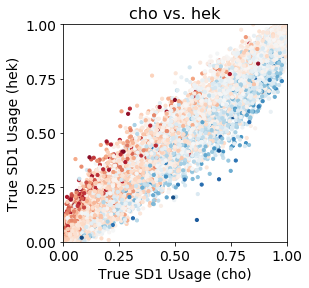

cho vs. hela
Delta PSI Test set R^2 = 0.12, p = 0.0


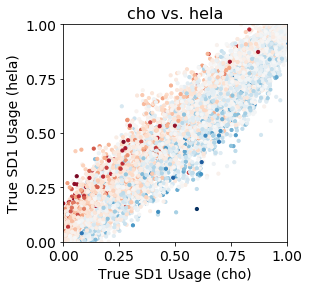

cho vs. mcf7
Delta PSI Test set R^2 = 0.54, p = 0.0


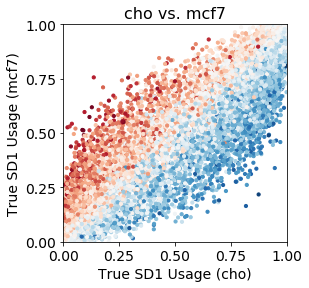

In [14]:
#Differential splicing test set evaluation

for cell_name_1, [y_pred_1, y_true_1] in cell_lines :
    for cell_name_2, [y_pred_2, y_true_2] in cell_lines :
        
        if cell_name_1 != cell_name_2 :
            
            print(cell_name_1 + " vs. " + cell_name_2)

            #Plot test set scatter
            f = plt.figure(figsize=(4, 4))
            
            diff_true = y_true_2 - y_true_1
            diff_pred = y_pred_2 - y_pred_1
            
            r_val, p_val = pearsonr(diff_pred, diff_true)
            print("Delta PSI Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))
            
            valid_index = (y_true_1 > 0.0) & (y_true_1 < 1.0)
            valid_index = valid_index & ((y_true_2 > 0.0) & (y_true_2 < 1.0))
            
            plt.scatter(y_true_1, y_true_2, c=diff_pred, cmap='RdBu_r', vmin=np.min(diff_pred), vmax=np.max(diff_pred), s=10, alpha=1.0)

            plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
            plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
            plt.xlabel('True SD1 Usage (' + cell_name_1 + ')', fontsize=14)
            plt.ylabel('True SD1 Usage (' + cell_name_2 + ')', fontsize=14)
            plt.title(cell_name_1 + " vs. " + cell_name_2, fontsize=16)

            plt.xlim(0, 1)
            plt.ylim(0, 1)

            plt.show()



In [16]:
pred_df = splicing_gens['test'].sources['df'].iloc[splicing_gens['test'].data_ids[:truncated_n]].copy()

pred_df['sd1_true_hek'] = true_usage_hek
pred_df['sd1_true_hela'] = true_usage_hela
pred_df['sd1_true_mcf7'] = true_usage_mcf7
pred_df['sd1_true_cho'] = true_usage_cho

pred_df['sd1_pred_hek'] = pred_usage_hek
pred_df['sd1_pred_hela'] = pred_usage_hela
pred_df['sd1_pred_mcf7'] = pred_usage_mcf7
pred_df['sd1_pred_cho'] = pred_usage_cho

pred_df['total_count_hek'] = splicing_gens['test'].sources['hek_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_hela'] = splicing_gens['test'].sources['hela_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_mcf7'] = splicing_gens['test'].sources['mcf7_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_cho'] = splicing_gens['test'].sources['cho_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)


pred_df.to_csv('a5ss_test_pred_' + model_name + '.csv', index=False, sep='\t')
